<a href="https://colab.research.google.com/github/yudahendriawan/google-colab-projects/blob/general/portfolio_traffic_sign_model_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Traffic Sign Classification Model

German Traffic Sign Dataset is a benchmark dataset for multi-class image classification. There is one traffic sign in each image, so this dataset is also called a single image. This dataset was first launched in a challenge organized by the International Joint Conference on Neural Networks (IJCNN) in 2011.

This dataset has the following components:

- Data for single image classification problems with many classes.
- Consists of 43 classes, meaning there are 43 types of traffic signs.
- Has a total of more than 50,000 images.
- Data taken from photos of actual signs (not synthetic).

The data we will use is in the form of a pickle file created with a Python module called pickle. It is used to convert Python objects into byte representations to be stored in storage or transferred over the network. This allows objects to be stored or transmitted easily without converting the data to another format first.

## Data Loading

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
training_file = "/content/drive/MyDrive/google-colab-datasets/german-traffic-sign-datasets/train.p"
testing_file = "/content/drive/MyDrive/google-colab-datasets/german-traffic-sign-datasets/test.p"

#open and load the training file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# open and load the testing file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print('Data Loaded')

Data Loaded


# Data Exploration

In [3]:
sign_name_df = pd.read_csv('/content/drive/MyDrive/google-colab-datasets/german-traffic-sign-datasets/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


# Data Preparation

Next, we will define features and labels on the loaded pickle data, then convert the lists to numpy arrays. We will do this on Training data and Testing data

In [4]:
X,y = train['features'],train['labels']

# convert lists to numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

X_test, y_test = test['features'], test['labels']

# convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


## Train-Test-Split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


Next, visualize the class distribution in the training, validation and testing data. We need to do this to see how the classes are distributed in each of the data above.

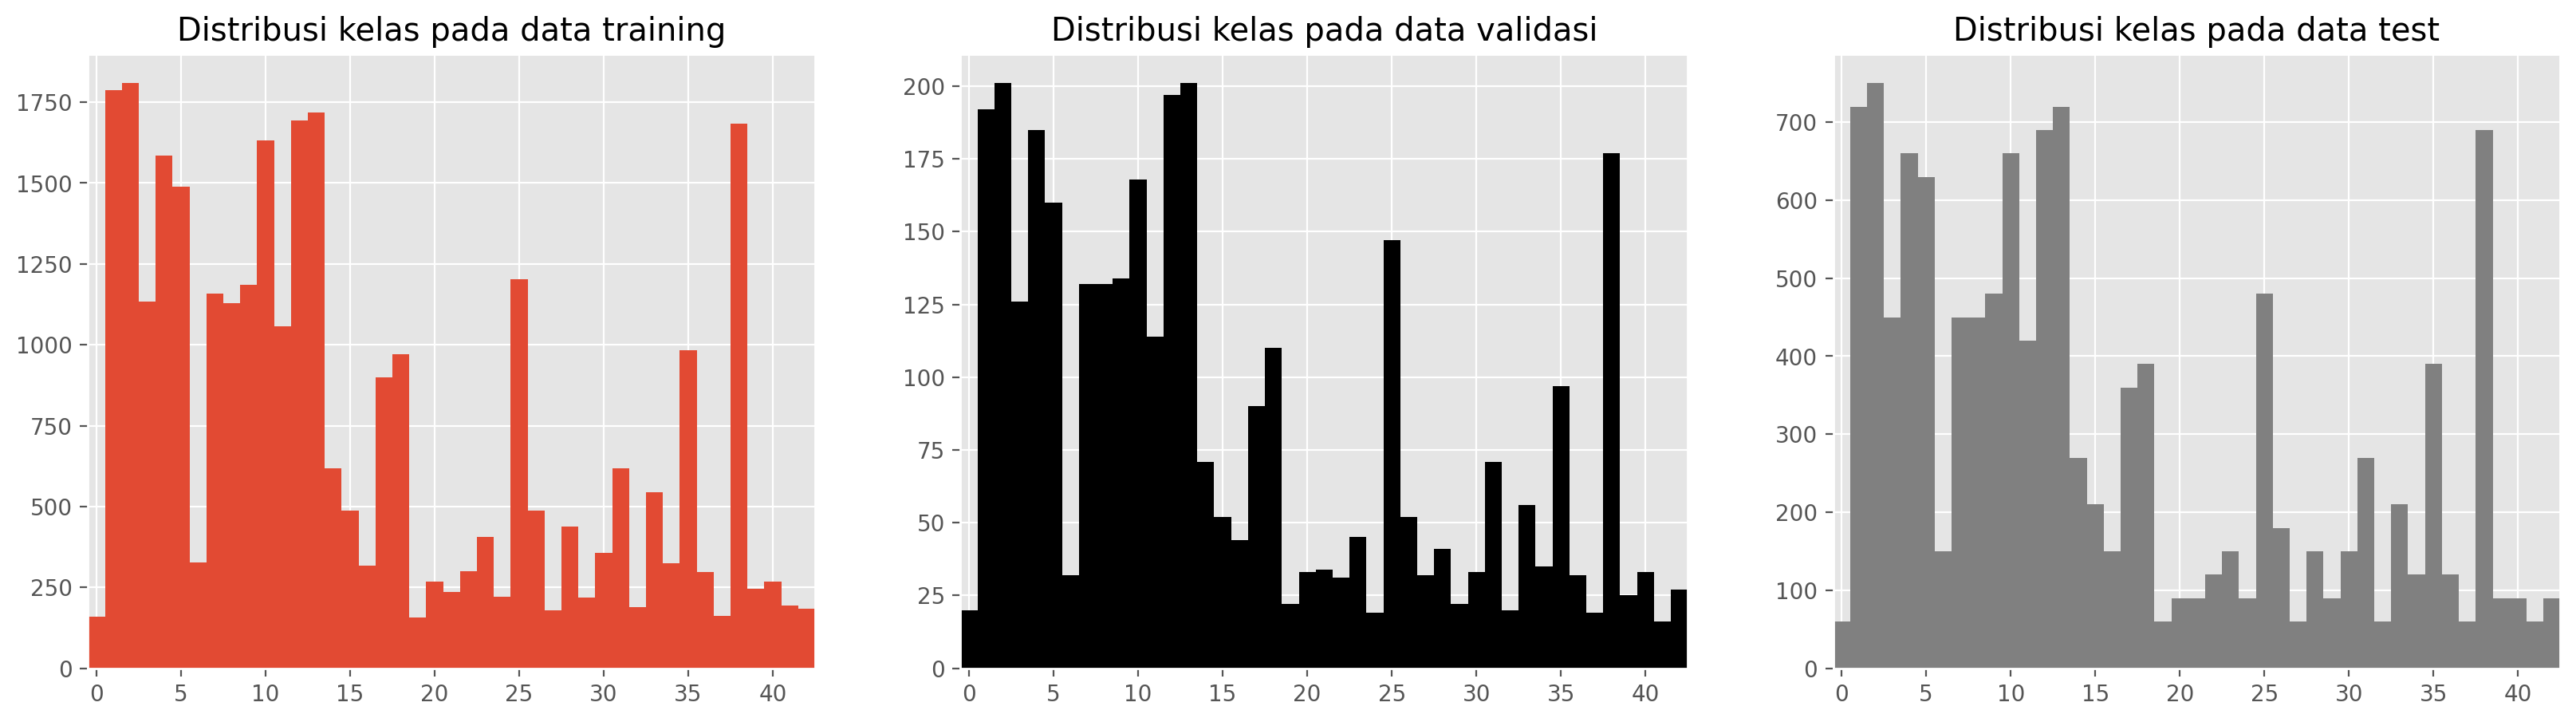

In [6]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)

fig, ax = plt.subplots(1,3,figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

From the picture, it can be seen that the class distribution of each piece of data looks similar. Therefore, we do not need to carry out a normalization process.

The next stage is Data Preparation. At this stage we will convert the labels in the training and validation data using the one hot encoding technique. The goal is that the label, which was previously a string data type, becomes a categorical feature. We will use the to_categorical function from the tensorflow library.

In [7]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

# Training with Convolutional Neural Network

Here we will directly implement the callback on the model. We set it so that training stops when the model accuracy reaches 96%. Using callbacks will shorten training time because we have defined at the beginning what accuracy values ​​are needed. So, when the model has reached that accuracy, the training process will stop.

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.96):
            print('\nAkurasi telah mencapai 96%. Stop training !')
            self.model.stop_training = True

callbacks = myCallback()

In this project, we use an architecture of 2 convolutional layers and 1 fully connected layer. For more details, let's discuss each layer.

First, initialize the Sequential model and determine the input shape for the model. This set of layers uses a 5x5 kernel to learn features in traffic sign data. We adjust the input to the shape X_train, which is an RGB image measuring 32 pixels (32, 32, 3). The activation function that we will use is RELU, as explained previously. We also add a Max Pooling layer to reduce dimensions.

Here, we also implement dropout. Dropout is a hyperparameter that aims to reduce overfitting. It works by disconnecting or dropping units during the neural network training process so that the layer or layers become inactive. According to documentation from Keras, the rate argument for dropout is a float data type between 0 and 1, which is the fraction of units to be dropped.

If we set dropout rate = 0.25, that is, we will drop 25% of the layer and make it inactive during the training process.

Here's our first set of layers. In this architecture, set the layer parameters as follows:

In [9]:
model = Sequential([
    #first layer
    Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]),
    Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(rate=0.25),
    #second layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    #fully connected layer
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [11]:
# compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val,y_val), callbacks=[callbacks])
model.save('my_model.h5')

Epoch 1/25
979/979 [==============================] - 12s 7ms/step - loss: 1.6087 - accuracy: 0.5843 - val_loss: 0.4394 - val_accuracy: 0.8761
Epoch 2/25
979/979 [==============================] - 5s 5ms/step - loss: 0.5843 - accuracy: 0.8237 - val_loss: 0.2169 - val_accuracy: 0.9319
Epoch 3/25
979/979 [==============================] - 6s 6ms/step - loss: 0.4090 - accuracy: 0.8770 - val_loss: 0.1575 - val_accuracy: 0.9563
Epoch 4/25
979/979 [==============================] - 6s 6ms/step - loss: 0.3216 - accuracy: 0.9030 - val_loss: 0.1394 - val_accuracy: 0.9601
Epoch 5/25
979/979 [==============================] - 5s 5ms/step - loss: 0.2711 - accuracy: 0.9226 - val_loss: 0.1354 - val_accuracy: 0.9626
Epoch 6/25
979/979 [==============================] - 6s 6ms/step - loss: 0.2401 - accuracy: 0.9307 - val_loss: 0.0926 - val_accuracy: 0.9747
Epoch 7/25
979/979 [==============================] - 5s 5ms/step - loss: 0.2241 - accuracy: 0.9351 - val_loss: 0.0726 - val_accuracy: 0.9793
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


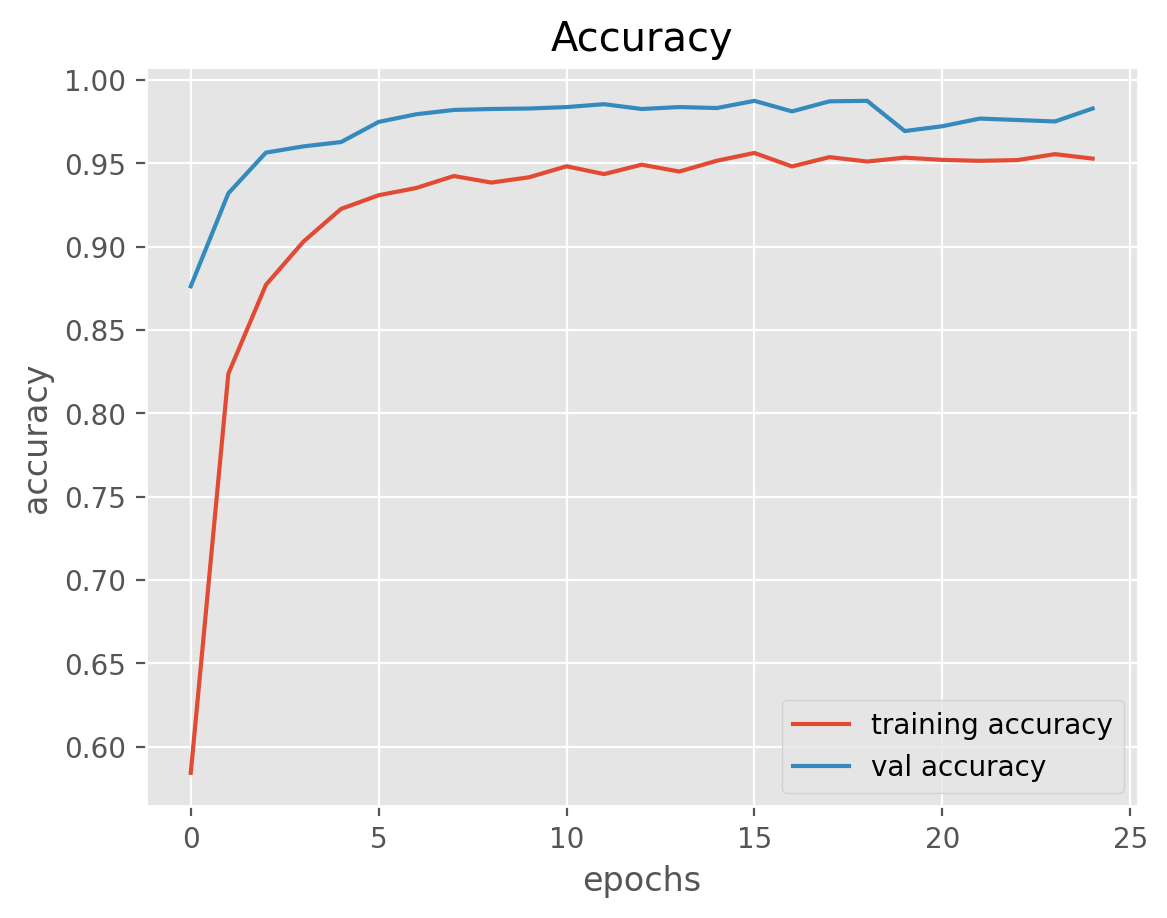

Text(0.5, 1.0, 'Loss')

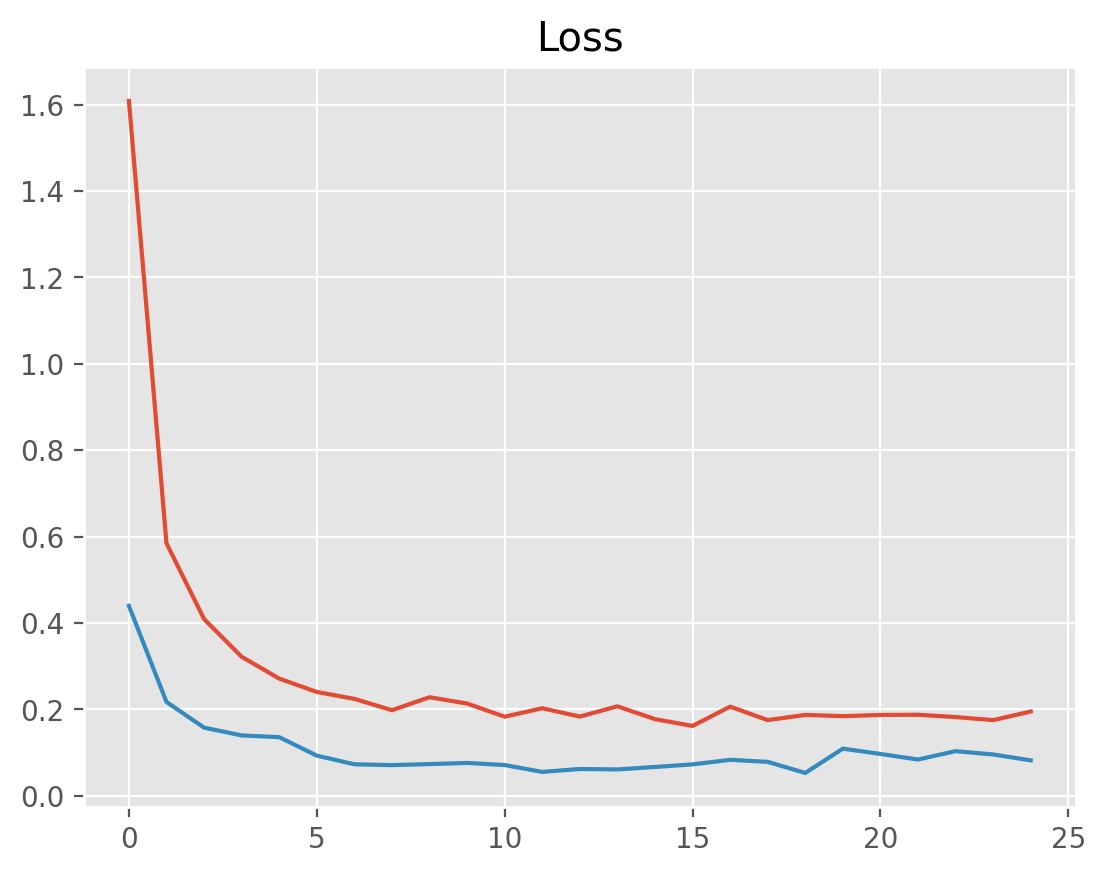

In [12]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')

# Testing Model

In the data exploration stage, we divide the data into three parts, namely training, validation and testing data. After obtaining results on training and validation data, we will test the model on data that has never been seen before, namely testing data

At this stage we use the accuracy_score function from the sklearn.metrics library. According to scikit-learn documentation, this function calculates subset accuracy on multiclass classification. Note that the set of predicted labels for a sample must exactly match the set of actual labels. In this case, the actual set of labels are the labels in the y_test data. Meanwhile, the prediction label is defined using the model.predict() function for the data in X_test and then entered into the pred variable.

In [13]:
# testing accuracy with the test data
from sklearn.metrics import accuracy_score

pred = np.argmax(model.predict(X_test), axis=1)
accuracy_score(y_test, pred)

395/395 [==============================] - 3s 6ms/step


0.9401425178147268

Similar to the accuracy results obtained in the training stage. This means that our model can adapt (fit) to new data well.

Next, to obtain other classification metrics such as precision, recall, and f1-score, let's apply the classification_report function from the sklearn library.

In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        60
           1       0.92      0.97      0.94       720
           2       0.94      0.97      0.95       750
           3       0.93      0.90      0.91       450
           4       1.00      0.94      0.96       660
           5       0.87      0.93      0.90       630
           6       0.97      0.87      0.92       150
           7       0.95      0.96      0.96       450
           8       0.97      0.92      0.94       450
           9       0.95      1.00      0.97       480
          10       0.99      0.98      0.99       660
          11       0.94      0.89      0.92       420
          12       0.97      0.96      0.97       690
          13       0.98      0.99      0.99       720
          14       1.00      0.92      0.96       270
          15       1.00      0.88      0.93       210
          16       0.99      0.99      0.99       150
          17       1.00    

If we pay attention to almost all classes, the accuracy of precision, recall and f1-score have high numbers, on average in the upper 90s. However, in some classes, such as classes with indexes 27 and 42, the average accuracy is below 80%. This could be caused by the fairly complex feature representation of these two classes.